In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget

from voxel import *
from mol_tools import *
from ML_utils import *

from sklearn.model_selection import train_test_split, KFold

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of molecules", df.shape[0])
    return df

In [3]:
def drop_low_frequency_elements(df, limit):
    elem_counts = pd.Series(np.hstack(np.array(df.species))).value_counts()
    low_freq = elem_counts[elem_counts < limit].index.values
    low_freq_mask = df.species.apply(lambda s: len(np.setdiff1d(s, low_freq)) < len(s))
    df = df[~low_freq_mask]
    print("Number of molecules", df.shape[0])
    return df

In [4]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [5]:
#df = pd.read_pickle("data/icsd_221_cp5_3_species.pkl")
#df = pd.read_pickle("data/all_221_cp5_3_species_oxides.pkl")
df = pd.read_pickle("data/all_3_species_oxides.pkl")

#df1 = pd.read_pickle(f"data/all_3_species_oxides.pkl")
#df2 = pd.read_pickle(f"data/all_sup4_species_oxides.pkl")
#df = df1.append(df2)


In [6]:
df = drop_duplicates(df)
df = drop_low_frequency_elements(df, 50)

Number of molecules 5456
Number of molecules 5237


In [7]:
elements = get_all_elements(df)
elements

array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
       'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Er', 'Eu', 'F', 'Fe',
       'Ga', 'Gd', 'Ge', 'H', 'Hf', 'Hg', 'I', 'In', 'Ir', 'K', 'La',
       'Li', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ni', 'O', 'Os',
       'P', 'Pb', 'Pd', 'Pr', 'Pt', 'Rb', 'Re', 'Rh', 'Ru', 'S', 'Sb',
       'Sc', 'Se', 'Si', 'Sn', 'Sr', 'Ta', 'Tc', 'Te', 'Ti', 'Tl', 'U',
       'V', 'W', 'Xe', 'Y', 'Zn', 'Zr'], dtype='<U2')

In [8]:
nchannel = len(elements)
nchannel

72

In [9]:
np.random.seed(0)
train_df, holdout_df = train_test_split(df, test_size=0.1)
val_df, test_df = train_test_split(holdout_df, test_size=0.5)
print(train_df.shape, val_df.shape, test_df.shape)

(4713, 13) (262, 13) (262, 13)


In [10]:
def make_simple_descriptor(mol, elements, one_hot=True):
    descriptor = np.zeros((len(elements),))
    
    for i, (element, n_atoms) in enumerate(zip(mol.species, mol.composition)):
        try:
            j = np.where(elements == element)[0][0] # get channel for element
            if one_hot:
                descriptor[j] = 1
            else:
                descriptor[j] = n_atoms
        except:
            print(element, mol.compound, mol.composition)
            
    return descriptor

In [11]:
df.loc[0]

auid                                                  aflow:b281fdee92d2d2b2
aurl                       aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOOs_pv/...
compound                                                            Ag1O3Os1
composition                                                        [1, 3, 1]
species                                                          [Ag, O, Os]
natoms                                                                     5
spacegroup                                                               221
pearson_symbol                                                           cP5
geometry                   [3.9184369, 3.9184369, 3.9184369, 90.0, 90.0, ...
positions_fractional       [[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...
positions_cartesian        [[0.0, 0.0, 0.0], [0.0, 1.95922, 1.95922], [1....
enthalpy_atom                                                       -5.34058
enthalpy_formation_atom                                             0.427456

In [12]:
make_simple_descriptor(df.loc[0], elements)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [13]:
seed_everything()
train_df, holdout_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(holdout_df, test_size=0.5)
print(train_df.shape, val_df.shape, test_df.shape)

(4189, 13) (524, 13) (524, 13)


In [14]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(4189, 13)
(524, 13)
(524, 13)


In [15]:
y = df.enthalpy_atom# * df.natoms
y_train = train_df.enthalpy_atom# * train_df.natoms
y_val = val_df.enthalpy_atom# * train_df.natoms
y_test = test_df.enthalpy_atom# * test_df.natoms

## Zero R

In [16]:
y_pred_train = np.mean(y_train)
print("MSE", np.mean((y_pred_train - y_train)**2))
print("MAE", np.mean(np.abs(y_pred_train - y_train)))

MSE 2.4728331680520563
MAE 1.2853477494382317


In [17]:
y_test_pred = np.mean(y_train)
print("MSE", np.mean((y_test_pred - y_test)**2))
print("MAE", np.mean(np.abs(y_test_pred - y_test)))

MSE 2.339913849842868
MAE 1.2588241006525636


## Ridge

In [18]:
one_hot=True

In [19]:
X_train = np.vstack(train_df.apply(lambda mol: make_simple_descriptor(mol, elements, one_hot=one_hot), axis=1))
X_test = np.vstack(test_df.apply(lambda mol: make_simple_descriptor(mol, elements, one_hot=one_hot), axis=1))

In [20]:
from  sklearn.linear_model import RidgeCV

In [21]:
rcv = RidgeCV()
rcv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [22]:
y_pred_train = rcv.predict(X_train)
print("MSE", np.mean((y_pred_train - y_train)**2))
print("MAE", np.mean(np.abs(y_pred_train - y_train)))

MSE 0.5673519588393615
MAE 0.5770557893000028


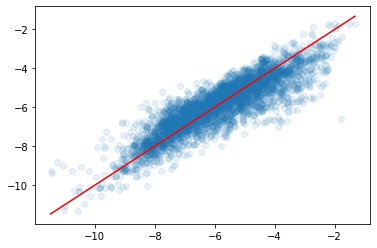

In [23]:
plt.scatter(y_train, y_pred_train, alpha=0.1)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c="red")
plt.show()

In [24]:
y_test_pred = rcv.predict(X_test)
print("MSE", np.mean((y_test_pred - y_test)**2))
print("MAE", np.mean(np.abs(y_test_pred - y_test)))

MSE 0.6068906598905726
MAE 0.5881107704559042


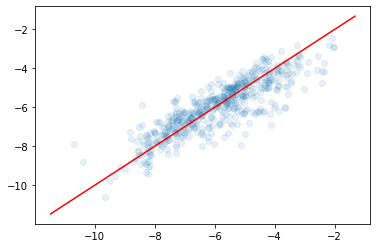

In [25]:
plt.scatter(y_test, y_test_pred, alpha=0.1)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c="red")
plt.show()

## MLP

In [26]:
one_hot = False

In [27]:
X_train = np.vstack(train_df.apply(lambda mol: make_simple_descriptor(mol, elements, one_hot=one_hot), axis=1))
X_test = np.vstack(test_df.apply(lambda mol: make_simple_descriptor(mol, elements, one_hot=one_hot), axis=1))

In [28]:
from sklearn.neural_network import MLPRegressor

In [29]:
mlp = MLPRegressor(random_state=0, max_iter=5000)
mlp.fit(X_train, y_train)

MLPRegressor(max_iter=5000, random_state=0)

In [30]:
y_pred_train = mlp.predict(X_train)
print("MSE", np.mean((y_pred_train - y_train)**2))
print("MAE", np.mean(np.abs(y_pred_train - y_train)))

MSE 0.1455410260301683
MAE 0.25566652388925265


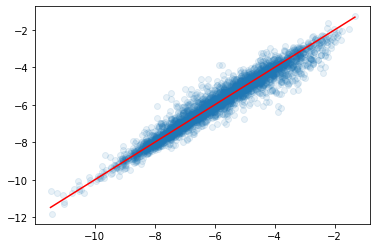

In [31]:
plt.scatter(y_train, y_pred_train, alpha=0.1)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c="red")
plt.show()

In [32]:
y_test_pred = mlp.predict(X_test)
print("MSE", np.mean((y_test_pred - y_test)**2))
print("MAE", np.mean(np.abs(y_test_pred - y_test)))

MSE 0.4117435863396188
MAE 0.39595799880343374


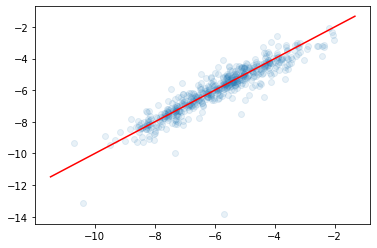

In [33]:
plt.scatter(y_test, y_test_pred, alpha=0.1)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c="red")
plt.show()